### **Part 1: Data Ingestion & Storage**


1. Programmatic Download

In [253]:
import requests
import os
import pandas as pd
import polars as pl
import duckdb
import time
import matplotlib.pyplot as plt
import numpy as np

# Make the data/raw directory if it doesn't exist
os.makedirs("data/raw", exist_ok=True)

files =[
    ("https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2024-01.parquet", "data/raw/yellowtripdata.parquet"),
    ("https://d37ci6vzurychx.cloudfront.net/misc/taxi_zone_lookup.csv","data/raw/zonelookup.csv")
]

for url, filepath in files:
    # Force re-download by removing the file if it exists
    if os.path.exists(filepath):
        os.remove(filepath)
        print(f"Removed existing file: {filepath}")

    print(f"Downloading NYC Taxi data to {filepath} ... ")
    response = requests.get(url)
    with open(filepath, 'wb') as f:
        f.write(response.content)
        print(f"Downloaded: {filepath} ({os.path.getsize(filepath) / 1e6 :.3f} MB)")

Removed existing file: data/raw/yellowtripdata.parquet
Downloaded: data/raw/yellowtripdata.parquet (49.962 MB)
Removed existing file: data/raw/zonelookup.csv
Downloaded: data/raw/zonelookup.csv (0.012 MB)


2. Data Validation

In [254]:

# Make the directory
os.makedirs("data/raw", exist_ok=True)
df_polars = pl.read_parquet("data/raw/yellowtripdata.parquet")

# a) Verify all expected columns exist in the dataset
print('\nColumn names and types:')
print(df_polars.schema)
req_cols = ["tpep_pickup_datetime","tpep_dropoff_datetime","PULocationID","DOLocationID","passenger_count","trip_distance","fare_amount","tip_amount","total_amount","payment_type"]
for x in req_cols:
  # print(x)
  if x not in df_polars.columns:
    raise ValueError("Missing column")

# b) Check that date columns are valid datetime types
# There are 2 date time colums tpep_pickup_datetime and tpep_dropoff_datetime
date_cols = ["tpep_pickup_datetime","tpep_dropoff_datetime"]
for x in date_cols:
  if df_polars.schema[x] != pl.Datetime:
    raise ValueError("Error incorrect data type")

# c) Report total row count and print a summary to the console
print(f'Total number of rows: {len(df_polars):,}')


Column names and types:
Schema({'VendorID': Int32, 'tpep_pickup_datetime': Datetime(time_unit='ns', time_zone=None), 'tpep_dropoff_datetime': Datetime(time_unit='ns', time_zone=None), 'passenger_count': Int64, 'trip_distance': Float64, 'RatecodeID': Int64, 'store_and_fwd_flag': String, 'PULocationID': Int32, 'DOLocationID': Int32, 'payment_type': Int64, 'fare_amount': Float64, 'extra': Float64, 'mta_tax': Float64, 'tip_amount': Float64, 'tolls_amount': Float64, 'improvement_surcharge': Float64, 'total_amount': Float64, 'congestion_surcharge': Float64, 'Airport_fee': Float64})
Total number of rows: 2,964,624


3. File Organization

In [255]:
# Make the directory
# This os.makedirs call is now handled in the download cell
# os.makedirs("data/raw", exist_ok=True)

# import shutil
# file_move = ["zonelookup.csv","yellowtripdata.parquet"]
# for x in file_move:
#     if not os.path.exists(f"data/raw/{x}"):
#       try:
#         shutil.move(f"{x}",f"data/raw/{x}")
#       except FileExistsError:
#         print("File already exist")

with open(".gitignore", "w") as f:
    f.write("data/\n")
#instead of downloaing the file and them moving it base on the instruction i can just download the file directly to the \data\raw

### **Part 2: Data Transformation & Analysis**

4. Data Cleaning

In [256]:
print(f"Original number of rows with no filtering = {len(df_polars):,}")
curr = len(df_polars)
#e) Removing rows with null values in critical columns (pickup/dropoff times, locations, fare)

check_col = ["tpep_pickup_datetime",
             "tpep_dropoff_datetime",
             "PULocationID",
             "DOLocationID",
             "fare_amount",
             "total_amount"]

filtered = df_polars.filter(pl.all_horizontal(
    (pl.col(check_col).is_not_null())
)).select([
    "tpep_pickup_datetime",
    "tpep_dropoff_datetime",
    "PULocationID",
    "DOLocationID",
    "passenger_count",
    "trip_distance",
    "fare_amount",
    "tip_amount",
    "total_amount",
    "payment_type"])
diff = curr- len(filtered)
print(f"Number of rows after null filtering = {len(filtered):,} rows removed = {diff} ")
curr = len(filtered)

#f) Filtering out invalid trips: trips with zero or negative distance, negative fares, or fares exceeding $500
filtered = filtered.filter(
    (pl.col("fare_amount")>= 0) &
    (pl.col("trip_distance") > 0) &
    (pl.col("fare_amount") < 500)
).select([
    "tpep_pickup_datetime",
    "tpep_dropoff_datetime",
    "PULocationID",
    "DOLocationID",
    "passenger_count",
    "trip_distance",
    "fare_amount",
    "tip_amount",
    "total_amount",
    "payment_type"])

diff = curr - len(filtered)
print(f"Number of rows after invalid trips filtering = {len(filtered):,} rows removed = {diff} ")
curr = len(filtered)

#g) Removing trips where dropoff time is before pickup time
filtered = filtered.filter(
    (pl.col("tpep_dropoff_datetime") > pl.col("tpep_pickup_datetime"))
).select([
    "tpep_pickup_datetime",
    "tpep_dropoff_datetime",
    "PULocationID",
    "DOLocationID",
    "passenger_count",
    "trip_distance",
    "fare_amount",
    "tip_amount",
    "total_amount",
    "payment_type"])
diff = curr- len(filtered)
print(f"Number of rows after drop off was before pick up = {len(filtered):,} rows removed = {diff} ")
curr = len(filtered)
df_polars = filtered

Original number of rows with no filtering = 2,964,624
Number of rows after null filtering = 2,964,624 rows removed = 0 
Number of rows after invalid trips filtering = 2,870,154 rows removed = 94470 
Number of rows after drop off was before pick up = 2,870,042 rows removed = 112 


5. Feature Engineering

In [257]:
enrich = df_polars.with_columns([
#i) trip_duration_minutes: calculated from pickup and dropoff timestamps
    ((pl.col("tpep_dropoff_datetime") - pl.col("tpep_pickup_datetime"))
    .dt.total_seconds() / 60).alias("trip_duration_minutes"),
])
enrich = enrich.with_columns([
#j) trip_speed_mph: distance divided by duration (handle division by zero)
          (
                  pl.when(pl.col("trip_duration_minutes") != 0)
                    .then(pl.col("trip_distance") / (pl.col("trip_duration_minutes") / 60))
                    .otherwise(None)
              ).alias("trip_speed_mph")
          ])
enrich = enrich.with_columns([
#k) pickup_hour: hour of day (0-23) extracted from pickup timestamp
    (pl.col("tpep_pickup_datetime").dt.hour()).alias("pickup_hour")
])

enrich = enrich.with_columns([
#l) pickup_day_of_week: day name (Monday-Sunday) extracted from pickup timestamp
    (pl.col("tpep_pickup_datetime").dt.strftime("%A")).alias("pickup_day_of_week")
])
enrich.select(["trip_duration_minutes","trip_speed_mph","trip_distance","pickup_hour","pickup_day_of_week"])



trip_duration_minutes,trip_speed_mph,trip_distance,pickup_hour,pickup_day_of_week
f64,f64,f64,i8,str
19.8,5.212121,1.72,0,"""Monday"""
6.6,16.363636,1.8,0,"""Monday"""
17.916667,15.739535,4.7,0,"""Monday"""
8.3,10.120482,1.4,0,"""Monday"""
6.1,7.868852,0.8,0,"""Monday"""
…,…,…,…,…
8.616667,22.143133,3.18,23,"""Wednesday"""
14.75,16.271186,4.0,23,"""Wednesday"""
19.0,10.515789,3.33,23,"""Wednesday"""


6. SQL Analysis

In [258]:
import duckdb

# m) What are the top 10 busiest pickup zones by total number of trips? (Include zone names from lookup table)

con = duckdb.connect()

con.register("data", enrich)

look = con.read_csv("data/raw/zonelookup.csv")

con.register("look", look)

result = con.execute("""
    SELECT d.PULocationID as LocationID,
      COUNT(*) as Frequency,
      l.Zone as Zone
    FROM data d
    JOIN look l
     ON d.PULocationID = l.LocationID
    GROUP BY PULocationID, l.Zone
    ORDER BY Frequency DESC
    LIMIT 10
""").fetchdf()
print("10 busiest pickup zones")
print(result)

10 busiest pickup zones
   LocationID  Frequency                          Zone
0         161     140161                Midtown Center
1         237     140131         Upper East Side South
2         132     138473                   JFK Airport
3         236     133975         Upper East Side North
4         162     104353                  Midtown East
5         230     102972     Times Sq/Theatre District
6         186     102160  Penn Station/Madison Sq West
7         142     101800           Lincoln Square East
8         138      87714             LaGuardia Airport
9         239      86473         Upper West Side South


In [259]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Above answers question
m) What are the top 10 busiest pickup zones by total number of trips? (Include zone
names from lookup table)

In [260]:
#n) What is the average fare amount for each hour of the day? (Order by hour)
result = con.execute("""
    SELECT pickup_hour as HourOfDay,
      COUNT(*) as Frequency,
      avg(fare_amount)
    FROM data d
    GROUP BY HourOfDay
""").fetchdf()
print("Average fare amount for each hour of the day")
print(result)

Average fare amount for each hour of the day
    HourOfDay  Frequency  avg(fare_amount)
0           0      75247         19.677365
1           1      50490         17.732268
2           2      34976         16.621723
3           3      22947         18.530557
4           4      15284         23.436246
5           5      17495         27.493833
6           6      39415         22.026585
7           7      80870         18.750217
8           8     113506         17.822275
9           9     125619         17.943563
10         10     135423         18.040405
11         11     146753         17.624825
12         12     159912         17.795682
13         13     165355         18.418028
14         14     178026         19.270612
15         15     184004         19.110658
16         16     184968         19.456974
17         17     200310         18.117847
18         18     206281         17.013177
19         19     178810         17.626669
20         20     155559         18.050304
21       

Above answers question
n) What is the average fare amount for each hour of the day? (Order by hour)

In [261]:
#o) What percentage of trips use each payment type?
result= con.execute("""
    SELECT payment_type,
          CASE payment_type
              WHEN 1 THEN 'Credit card'
              WHEN 2 THEN 'Cash'
              WHEN 3 THEN 'No charge'
              WHEN 4 THEN 'Dispute'
              WHEN 5 THEN 'Unknown'
              else 'Unknown'
          END as Payment,
          ROUND(COUNT(payment_type)* 100/(SELECT COUNT(*) FROM data),2) as Percentage,

    FROM data
    GROUP BY payment_type
    ORDER BY payment_type
""").fetchdf()
print(result)

   payment_type      Payment  Percentage
0             0      Unknown        4.02
1             1  Credit card       80.08
2             2         Cash       14.74
3             3    No charge        0.37
4             4      Dispute        0.80


Above answers question
o) What percentage of trips use each payment type?

In [262]:
#p) What is the average tip percentage (tip_amount/fare_amount) by day of week, for credit card payments only?
result= con.execute("""
    SELECT pickup_day_of_week as 'Day of the Week',
      ROUND(AVG(tip_amount/fare_amount)*100,2) as 'Tip percentage'
    FROM data
    WHERE payment_type = 1 AND
          tip_amount != 0 AND
          fare_amount != 0
    GROUP BY pickup_day_of_week
    ORDER BY CASE pickup_day_of_week
             WHEN 'Monday' THEN 1
             WHEN 'Tuesday' THEN 2
             WHEN 'Wednesday' THEN 3
             WHEN 'Thursday' THEN 4
             WHEN 'Friday' THEN 5
             WHEN 'Saturday' THEN 6
             WHEN 'Sunday' THEN 7
         END
""").fetchdf()
print(result)

  Day of the Week  Tip percentage
0          Monday           26.86
1         Tuesday           26.98
2       Wednesday           26.90
3        Thursday           31.13
4          Friday           26.94
5        Saturday           27.56
6          Sunday           26.35


Above answers question
p) What is the average tip percentage (tip_amount/fare_amount) by day of week, for
credit card payments only?

In [263]:
#q) What are the top 5 most common pickup-dropoff zone pairs? (Include zone names)
result= con.execute("""
    SELECT l1.Zone as PickupLocation,
           l2.Zone as DropoffLocation,
           COUNT(*) as Trip_count
    FROM data d
    JOIN look l1
      ON d.PULocationID = l1.LocationID
    JOIN look l2
      ON d.DOLocationID = l2.LocationID
    GROUP BY l1.Zone,l2.Zone
    ORDER BY Trip_count DESC
    LIMIT 5
""").fetchdf()
print(result)

          PickupLocation        DropoffLocation  Trip_count
0  Upper East Side South  Upper East Side North       21642
1  Upper East Side North  Upper East Side South       19199
2  Upper East Side North  Upper East Side North       15200
3  Upper East Side South  Upper East Side South       14116
4         Midtown Center  Upper East Side South       10139



Above answers question
q) What are the top 5 most common pickup-dropoff zone pairs? (Include zone names)



### Part 3: Dashboard Development

/tmp/ipython-input-210188625.py:6: DeprecationWarning:

`GroupBy.count` was renamed; use `GroupBy.len` instead



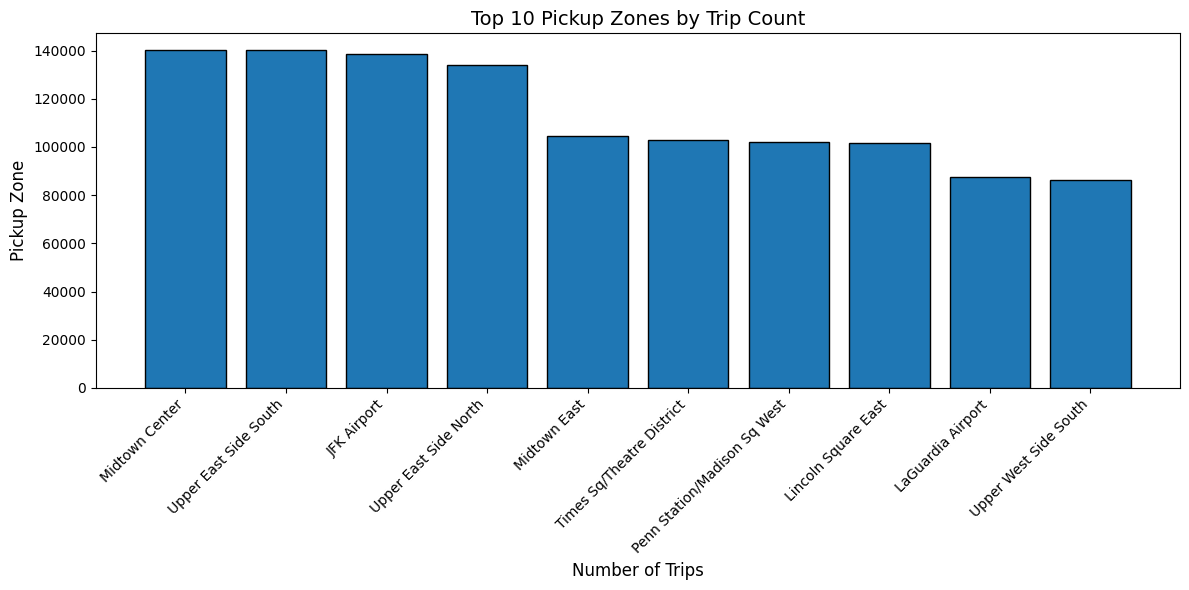

Most popular zone: Upper West Side Southwith 86,473 trips


In [264]:
# r) Bar chart: Top 10 pickup zones by trip count
zone_lookup = pl.read_csv("data/raw/zonelookup.csv")

top_pickups = (
    enrich.group_by("PULocationID")
    .count()
    .sort("count", descending=True)
    .head(10)
    .join(zone_lookup, left_on="PULocationID", right_on="LocationID")
)

top_pickups_pd = top_pickups.to_pandas()
top_pickups_pd = top_pickups_pd.sort_values("count", ascending=False)

plt.figure(figsize=(12, 6))
plt.bar(top_pickups_pd["Zone"], top_pickups_pd["count"], edgecolor="black")

plt.xlabel("Number of Trips", fontsize=12)
plt.ylabel("Pickup Zone", fontsize=12)
plt.title("Top 10 Pickup Zones by Trip Count", fontsize=14)

plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

print(f"Most popular zone: {top_pickups_pd.iloc[-1]['Zone']}with {top_pickups_pd.iloc[-1]['count']:,} trips")

Most trips start in a few very busy areas of the city. This shows that taxi demand is much higher in popular area (see the most comon pair trips previously). Taxi usage is not evenly spread across all zones.

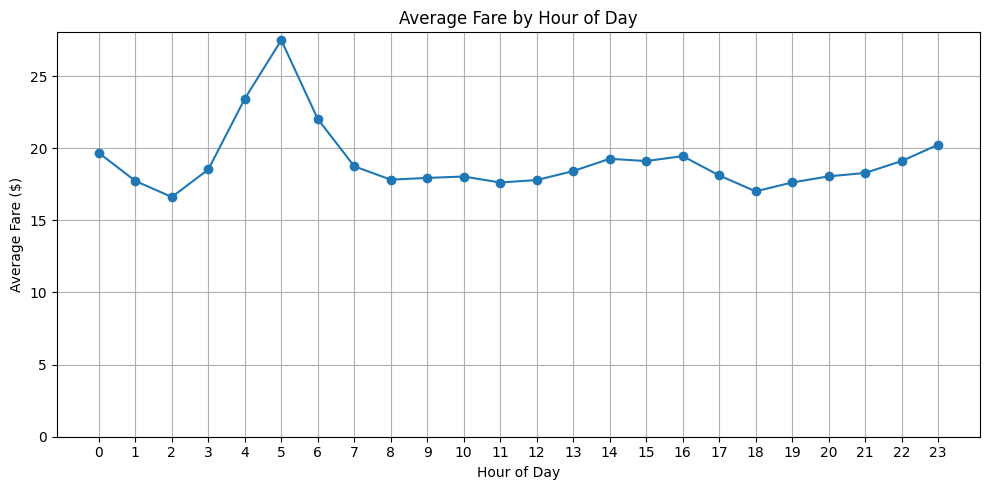

In [265]:
# s) Line chart: Average fare by hour of day (showing hourly patterns)
avg_fare_hour = (
    enrich.group_by("pickup_hour")
    .agg(pl.col("fare_amount").mean().alias("avg_fare"))
    .sort("pickup_hour")
)

plt.figure(figsize=(10, 5))
plt.plot(
    avg_fare_hour["pickup_hour"].to_list(),
    avg_fare_hour["avg_fare"].to_list(),
    marker="o"
)

plt.xlabel("Hour of Day")
plt.ylabel("Average Fare ($)")
plt.title("Average Fare by Hour of Day")
plt.xticks(range(24))

plt.grid(True)
plt.ylim(bottom=0)
plt.tight_layout()
plt.show()

Fares change depending on the time of day. Prices are usually higher during busy hours like morning and evening. This likely happens because more people are traveling at those times.

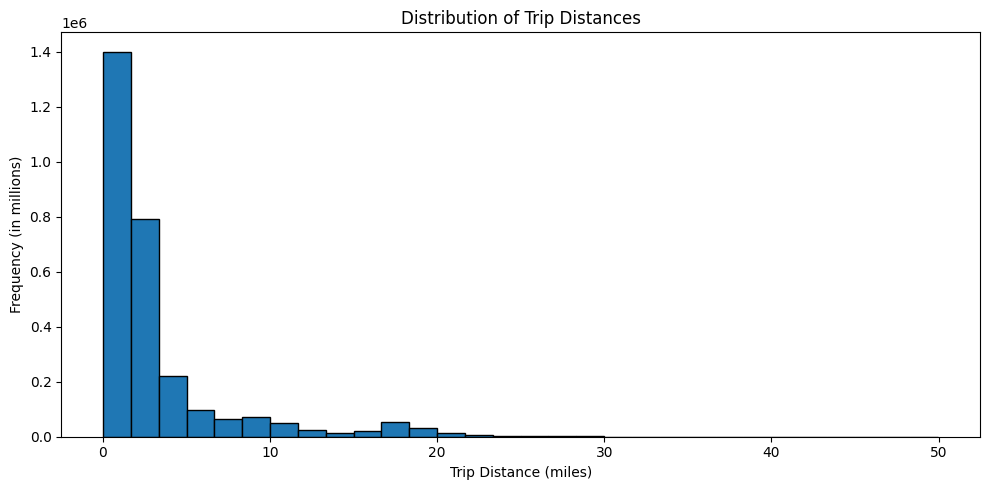

In [266]:
#t) Histogram: Distribution of trip distances (with appropriate binning)

distance_data = (
    enrich
    .filter(pl.col("trip_distance") < 50)
    ["trip_distance"]
    .to_list()
)

plt.figure(figsize=(10, 5))
plt.hist(distance_data, bins=30, edgecolor="black")

plt.xlabel("Trip Distance (miles)")
plt.ylabel("Frequency (in millions)")
plt.title("Distribution of Trip Distances")
plt.tight_layout()
plt.show()

/tmp/ipython-input-1902094593.py:13: DeprecationWarning:

`GroupBy.count` was renamed; use `GroupBy.len` instead



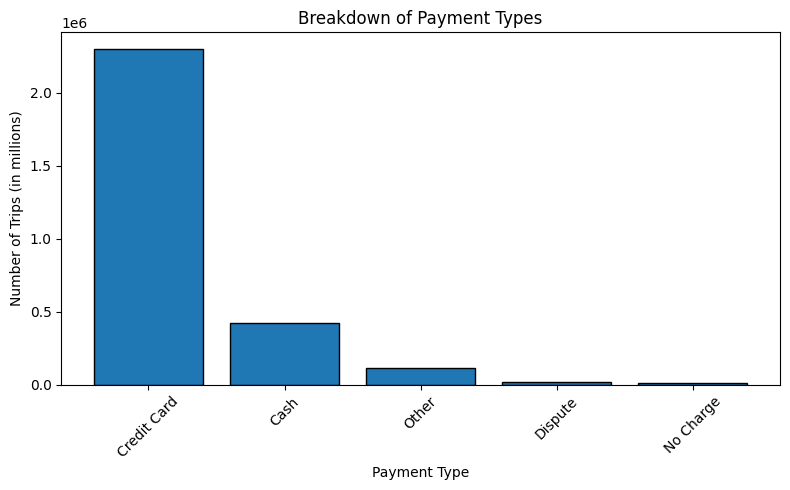

In [267]:
# u) Pie or bar chart: Breakdown of payment types
payment_lookup = {
    1: "Credit Card",
    2: "Cash",
    3: "No Charge",
    4: "Dispute",
    5: "Unknown",
    6: "Voided Trip"
}

payment_counts = (
    enrich.group_by("payment_type")
    .count()
    .sort("count", descending=True)
)

labels = [payment_lookup.get(x, "Other") for x in payment_counts["payment_type"].to_list()]
values = payment_counts["count"].to_list()

plt.figure(figsize=(8, 5))
plt.bar(labels, values, edgecolor="black")

plt.xlabel("Payment Type")
plt.ylabel("Number of Trips (in millions)")
plt.title("Breakdown of Payment Types")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Most people pay by credit card. Fewer people use cash. This shows that digital payments are more common than cash for taxi rides.

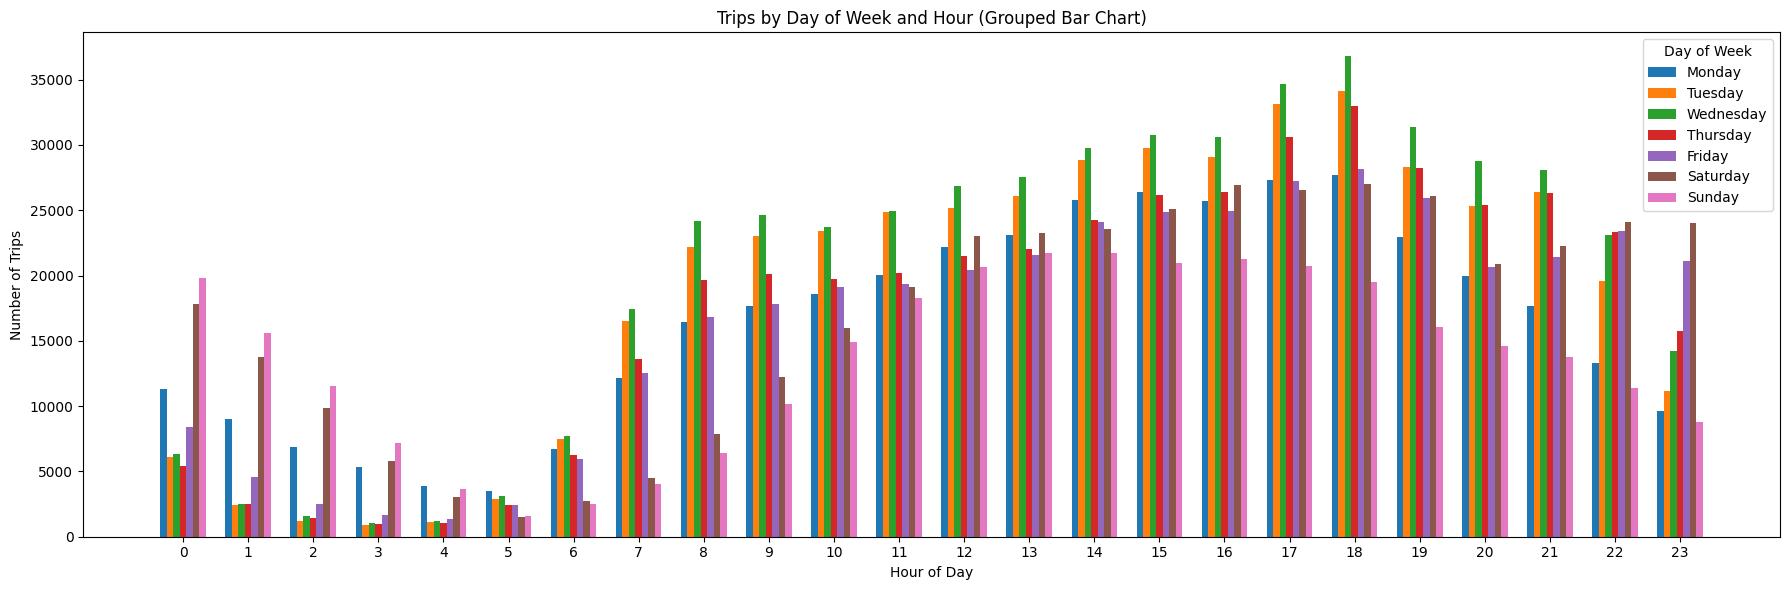

In [268]:
#v) Heatmap or grouped bar chart: Trips by day of week and hour (showing weekly patterns)
# --- Aggregate trips by day of week and hour ---
heatmap_data = (
    enrich
    .with_columns([
        pl.col("tpep_pickup_datetime").dt.hour().alias("pickup_hour"),
        pl.col("tpep_pickup_datetime").dt.weekday().alias("pickup_day_of_week")
    ])
    .group_by(["pickup_day_of_week", "pickup_hour"])
    .agg(pl.len().alias("trips"))
    .sort(["pickup_day_of_week", "pickup_hour"])
)

# --- Map day numbers to names ---
days_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

heatmap_data = heatmap_data.with_columns([
    pl.col("pickup_day_of_week").map_elements(
        lambda x: days_order[x - 1] if 0 < x <= len(days_order) else "Unknown",
        return_dtype=pl.String
    ).alias("day_name")
])

# --- Pivot to get matrix (7 days x 24 hours) ---
pivot = heatmap_data.pivot(
    values="trips",
    index="day_name",
    on="pickup_hour"
).fill_null(0)

# Ensure days are in correct order
pivot = pivot.select([pl.col(day) for day in days_order] if all(day in pivot.columns for day in days_order) else pivot.columns)

matrix = pivot.to_numpy()

# Plot grouped bar chart
hours = np.arange(24)
num_days = len(days_order)
width = 0.1
offset = (num_days / 2) * width

plt.figure(figsize=(18, 6))
for i, day in enumerate(days_order):
    plt.bar(hours - offset + i * width + width/2, matrix[i][1:], width=width, label=day)

plt.xlabel("Hour of Day")
plt.ylabel("Number of Trips")
plt.title("Trips by Day of Week and Hour (Grouped Bar Chart)")
plt.xticks(hours, hours)
plt.legend(title="Day of Week")
plt.tight_layout()
plt.show()

There are more trips during weekday mornings and evenings because of work travel. Weekend nights are also busy due to social activities. Travel patterns clearly change between weekdays and weekends.

# Ai usage
During the completion of this assignment, I used AI assistance to help understand specific Python and Polars functionality, including how to extract specific parts of a timestamp (such as the hour), how to get the day of the week without using .dt.weekday(), how to move files from one location to another, and how to retrieve a list of column names from a Parquet file. Additionally, I used AI guidance for instructions on creating different interactive elements in Streamlit, such as sliders, dropdowns, and multiselect filters.
